In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True' 

In [2]:
import torch
import torch.nn as nn
from d2l import torch as d2l

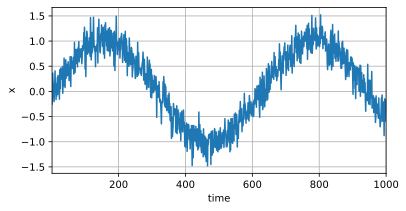

In [3]:
T = 1000  # 序列长度,总共产生1000个点
time = torch.arange(1,T+1,dtype=torch.float32)
x = torch.sin(0.01*time) + torch.normal(0,0.2,size=(T,))
d2l.plot(time, [x], 'time', 'x', xlim=[1,T], figsize=(6,3))

In [4]:
tau = 4
features = torch.zeros((T - tau,tau))
for i in range(tau):
    features[:,i] = x[i:T-tau+i]
labels = x[tau:].reshape(-1,1)

In [23]:
print(x[:10],features[:10],labels[:10])

tensor([ 0.0009, -0.1035, -0.0904,  0.0710, -0.1437, -0.1540, -0.2646,  0.0601,
         0.0349,  0.3361]) tensor([[ 0.0009, -0.1035, -0.0904,  0.0710],
        [-0.1035, -0.0904,  0.0710, -0.1437],
        [-0.0904,  0.0710, -0.1437, -0.1540],
        [ 0.0710, -0.1437, -0.1540, -0.2646],
        [-0.1437, -0.1540, -0.2646,  0.0601],
        [-0.1540, -0.2646,  0.0601,  0.0349],
        [-0.2646,  0.0601,  0.0349,  0.3361],
        [ 0.0601,  0.0349,  0.3361,  0.2900],
        [ 0.0349,  0.3361,  0.2900,  0.3253],
        [ 0.3361,  0.2900,  0.3253,  0.0602]]) tensor([[-0.1437],
        [-0.1540],
        [-0.2646],
        [ 0.0601],
        [ 0.0349],
        [ 0.3361],
        [ 0.2900],
        [ 0.3253],
        [ 0.0602],
        [ 0.3411]])


In [5]:
batch_size,n_train = 16,600
# 只有前n_train个时间步的数据用于训练
train_iter  = d2l.load_array((features[:n_train],labels[:n_train]),batch_size,is_train=True)

In [6]:
# 初始化权重
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

def get_net():
    net = nn.Sequential(
        nn.Linear(4, 10),
        nn.ReLU(),
        nn.Linear(10, 1)
    )
    net.apply(init_weights)
    return net

# 平方损失注意：MSELoss 计算平方误差时不带系数1/2
loss = nn.MSELoss(reduction='none')


In [7]:
def train(net, train_iter, loss, epochs,lr):
    trainer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.sum().backward()
            trainer.step()
        print(f'epoch {epoch + 1}', f'loss {d2l.evaluate_loss(net, train_iter, loss):f}')
        

In [8]:
net = get_net()
train(net,train_iter,loss,5,0.01)

epoch 1 loss 0.086432
epoch 2 loss 0.065497
epoch 3 loss 0.060475
epoch 4 loss 0.056902
epoch 5 loss 0.052195


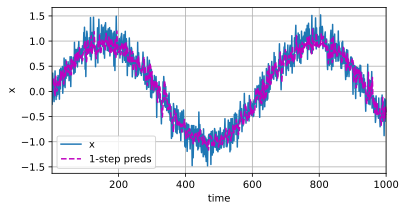

In [11]:
onestep_preds = net(features)
d2l.plot([time,time[tau:]],[x.detach().numpy(),onestep_preds.detach().numpy()],'time','x',legend=['x','1-step preds'],xlim=[1,1000],figsize=(6,3))

In [12]:
multistep_preds = torch.zeros(T)
multistep_preds[:n_train+tau] = x[:n_train+tau]
for i in range(n_train+tau, T):
    multistep_preds[i] = net(multistep_preds[i-tau:i]).reshape((1, -1))

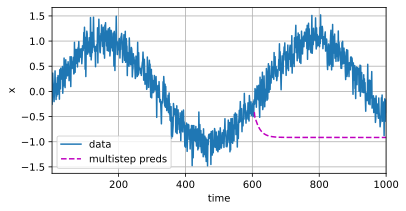

In [13]:
d2l.plot([time,time[n_train+tau:]],[x.detach().numpy(),
         multistep_preds[n_train+tau:].detach().numpy()],'time','x',legend=['data','multistep preds'],
         xlim=[1,1000],figsize=(6,3))

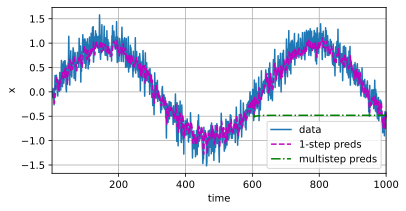

In [31]:
d2l.plot([time,time[tau:],time[n_train+tau:]],[x.detach().numpy(),onestep_preds.detach().numpy(),
         multistep_preds[n_train+tau:].detach().numpy()],'time','x',legend=['data','1-step preds','multistep preds'],
         xlim=[1,1000],figsize=(6,3))

In [33]:
max_steps = 64

features = torch.zeros((T - tau - max_steps + 1,tau + max_steps))
# 列i(i< tau) 是来自x的观测，其时间步从(i+1) 到 (i + T - tau - max_steps + 1)
for i in range(tau):
    features[:,i] = x[i:i+T-tau-max_steps+1]
# 列i(i>=tau) 是来自x的预测，其时间步从(i+1) 到 (i + T - tau - max_steps + 1)
for i in range(tau,tau+max_steps):
    features[:,i] = net(features[:,i-tau:i]).reshape(-1)

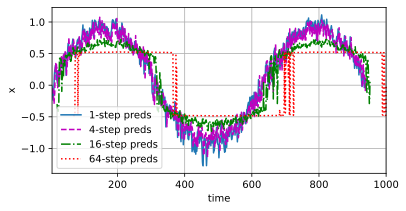

In [34]:
steps = (1,4,16,64)
d2l.plot([time[tau + i -1:T - max_steps + i] for i in steps],
         [features[:,(tau + i -1)].detach().numpy() for i in steps],
         'time','x',legend=[f'{i}-step preds' for i in steps],xlim=[5,1000],figsize=(6,3))